# **Reusing Pretrained Layers**

It is generally not a good idea to train a very large DNN from scratch: instead, you should always try to find an existing neural network that accomplishes a similar task to the one you are trying to tackle.

---

Just reuse the lower layers of this network
- It is called "transfer learning"

---

> For example, suppose that you have access to a DNN that was trained to classify pictures into 100 different categories, including animals, plants, vehicles, and everyday objects. You now want to train a DNN to classify specific types of vehicles. These tasks are very similar, even partly overlapping, so you should try to reuse parts of the first network.

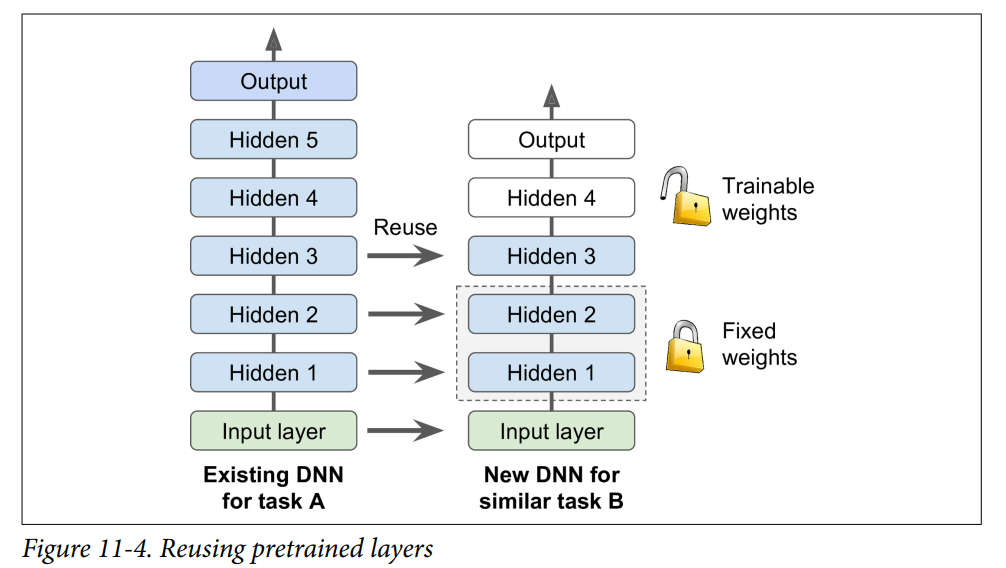

The **Output Layer** of the original model should usually be replaced since it is most likely not useful at all for the new task, and it may not even have the right number of outputs for the new task.

Similarly, the **upper hidden layers** of the original model are less likely to be as useful as the lower layers, since the high-level features that are most useful for the new task may differ significantly from the ones that were most useful for the original task. You want to find the right number of layers to reuse.

> The more similar the tasks are, the more layers you want to reuse
(starting with the lower layers). For very similar tasks, you can try
keeping all the hidden layers and just replace the output layer.

---

# **Transfer Learning With Keras**

Example: Someone built and trained a Keras model on that set and got reasonably good performance (>90% accuracy). Let’s call this model A. You now want to tackle a different task: you have images of sandals and shirts, and you want to train a binary classifier (positive=shirts, negative=sandals). However, your dataset is quite small, you only have 200 labeled images. When you train a new model for this task (let’s call it model B), with the same architecture as model A, it performs reasonably well (97.2% accuracy), but since it’s a much easier task (there are just 2 classes), you were hoping for more.

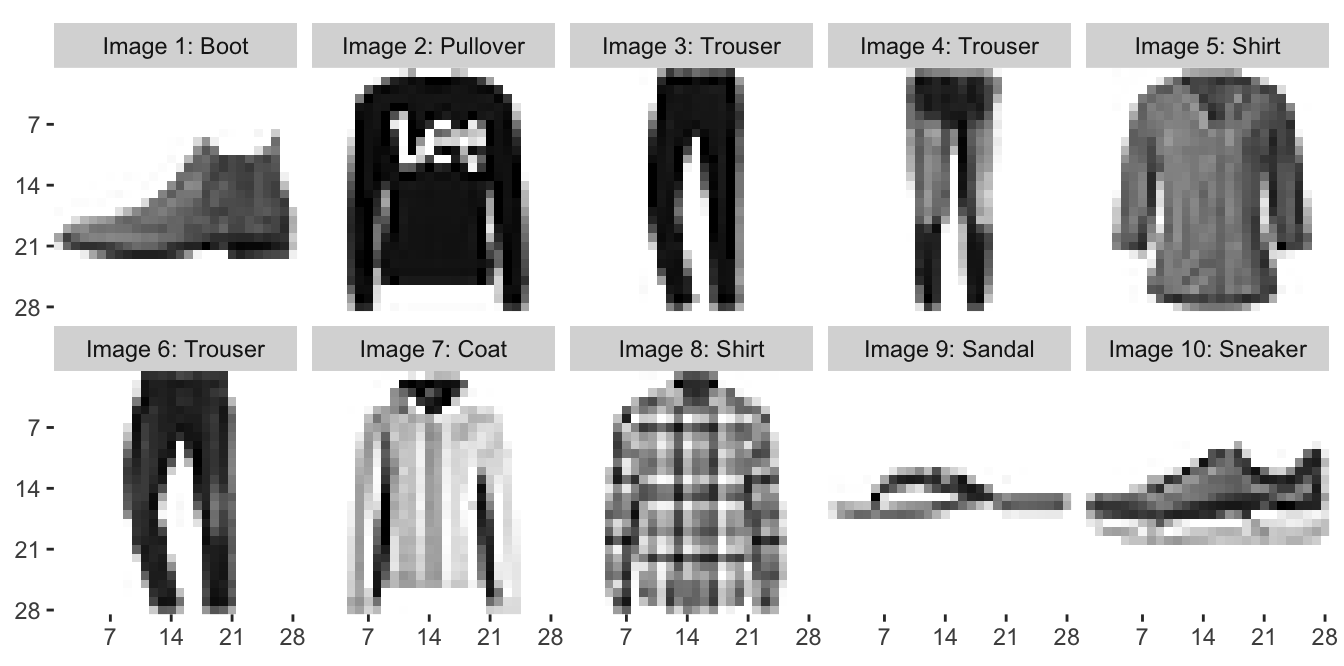

While drinking your morning coffee, you realize that your task is quite similar to task A, so perhaps transfer learning can help!

First, you need to load model A, and create a new model based on the model A’s layers. Let’s reuse all layers except for the output layer:

```python
model_A = keras.models.load_model("my_model_A.h5")
model_B_on_A = keras.models.Sequential(model_A.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))
```

Note that model_A and model_B_on_A now share some layers. When you train
model_B_on_A, **it will also affect model_A**. If you want to avoid that, you need to clone model_A before you reuse its layers. To do this, you must clone model A’s architecture, **then copy its weights** (since clone_model() does not clone the weights):

```python
model_A_clone = keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())
```

> **Importance**: Now we could just train model_B_on_A for task B, but since the new output layer was initialized randomly, it will make large errors, at least during the first few epochs, so there will be large error gradients that may wreck the reused weights.

To avoid this,

one approach is to freeze the reused layers during the first few epochs, giving the new layer some time to learn reasonable weights. To do this, simply set every layer’s trainable attribute to False and compile the model:

```python
for layer in model_B_on_A.layers[:-1]:
 layer.trainable = False

model_B_on_A.compile(loss="binary_crossentropy", optimizer="sgd", metrics=['accuracy'])
```

**Note: You must always compile your model after you freeze or unfreeze layers**

---

Next, we can train the model for a few epochs,
- then **unfreeze the reused layers** (which requires compiling the model again)
- continue training to fine-tune the reused layers for task B.

After unfreezing the reused layers, it is usually a good idea to **reduce the learning rate**, once again to avoid damaging the reused weights:

```python
# Train model with first few epoches
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
 validation_data=(X_valid_B, y_valid_B))

# Unfreezing layers
for layer in model_B_on_A.layers[:-1]:
 layer.trainable = True

# Compile model again, reducing lr
optimizer = keras.optimizers.SGD(lr=1e-4) # the default lr is 1e-3

model_B_on_A.compile(loss="binary_crossentropy", optimizer=optimizer,
 metrics=["accuracy"])

# Train model
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
 validation_data=(X_valid_B, y_valid_B))

```

Well this model’s test accuracy is 99.25%, which means
that transfer learning reduced the error rate from 2.8% down to almost 0.7%!

```python
# Testing model
model_B_on_A.evaluate(X_test_B, y_test_B)
[0.06887910133600235, 0.9925]
```


---

# Plot twist

Are you convinced? (Well you shouldn’t be: I cheated! :) I tried many configurationsuntil I found one that demonstrated a strong improvement. If you try to change the classes or the random seed, you will see that the improvement generally drops, or even vanishes or reverses. What I did is called “torturing the data until it confesses”.


> When a paper just looks too positive, you should be suspicious: perhaps the flashy new technique does not help much (in fact, it may even degrade performance), but the authors tried many variants and reported only the best results (which may be due to shear luck), without mentioning how many failures they encountered on the way.


Most of the time, this is not malicious at all, but it is part of the reason why so many results in Science can never be reproduced.


So why did I cheat? Well it turns out that transfer learning does not work very well with small dense networks: it works best with deep convolutional neural networks, so we will revisit transfer learning in **"Deep CV using CNNs"**, using the same techniques (and this time there will be no cheating, I promise!).

### **Double Bang 💥**

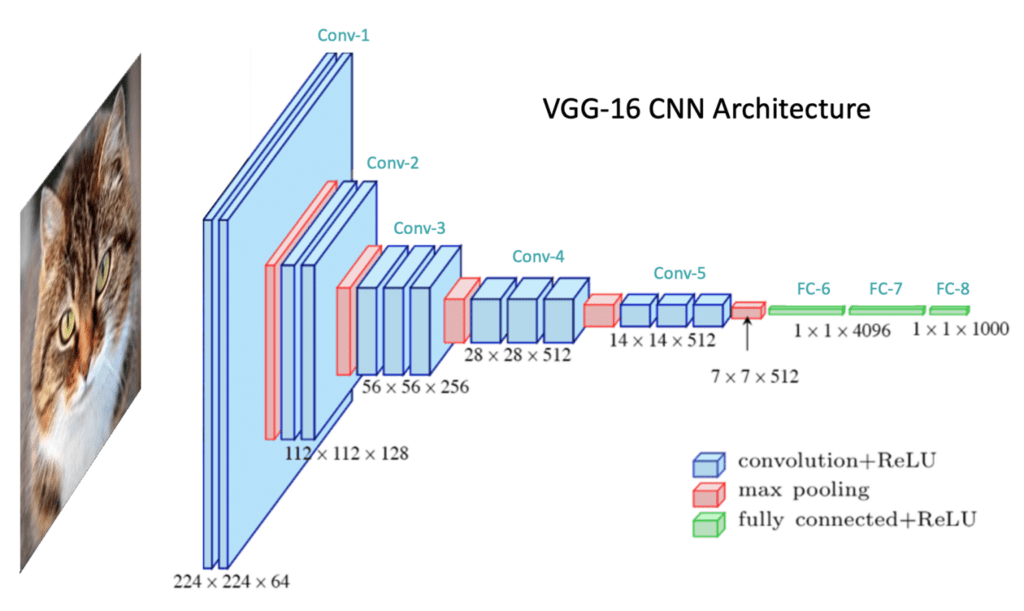